# Fast Holdout Evaluation (BRSET + MBRSET)

This notebook builds a **single 80/20 patient-level split per dataset** and reuses it for every embeddings file.
That guarantees a fair, like-for-like comparison across models and embeddings.

We evaluate:
- **Binary DR tasks**: `task_any_diab_retino`, `task_ref_macular`
- **3-class DR task**: `task_3class`

> Note: embeddings are already numeric, so we skip heavy preprocessing and focus on clean labels and consistent splits.

In [1]:
from pathlib import Path
import importlib
import pandas as pd

import src.retina_evaluation as reval
from src.retina_benchmark import list_embeddings_csvs
from src.retina_embeddings_dataset import load_retina_embeddings_dataset

reval = importlib.reload(reval)

PROJECT_ROOT = Path.cwd()
VAL_FRAC = 0.2
RANDOM_SEED = 13
MODEL_NAMES = ["lgbm", "mlp"]

DATASETS = [
    {"name": "brset", "view": "all"},
    {"name": "mbrset", "view": "macula"},
]
BINARY_TASK_MAP = {
    "task_any_dr": "task_any_diab_retino",
    "task_referable": "task_ref_macular",
}
BINARY_TASKS = list(BINARY_TASK_MAP.keys())

In [13]:
# total patient count brset and mbrset

import pandas as pd

def _patient_col_from_labels(labels_df: pd.DataFrame) -> str:
    # Prefer canonical name, but MBRSET uses `patient`
    for cand in ("patient_id", "patient", "subject_id", "SubjectID", "PatientID"):
        if cand in labels_df.columns:
            return cand
    # Heuristic fallback
    lower_map = {c.lower(): c for c in labels_df.columns}
    for cand in ("patient", "patient_id", "patientid", "subject_id"):
        if cand in lower_map:
            return lower_map[cand]
    raise ValueError(f"Could not infer patient column from labels columns: {list(labels_df.columns)[:15]}...")

def _unique_patients_in_labels(dataset_name: str) -> int:
    _, labels_path = _paths_for_dataset(dataset_name)
    labels_df = pd.read_csv(labels_path)
    patient_col = _patient_col_from_labels(labels_df)
    return labels_df[patient_col].nunique()

def _unique_patients_in_used_df(dataset_name: str, view: str) -> int:
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    if not embedding_files:
        raise FileNotFoundError(f"No embeddings CSVs found in {embed_dir}")
    ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=embedding_files[0],
        labels_csv_path=labels_path,
        view=view,
    )
    return ds.df["patient_id"].nunique()

for cfg in DATASETS:
    name, view = cfg["name"], cfg["view"]

    total_labels = _unique_patients_in_labels(name)
    total_used = _unique_patients_in_used_df(name, view)

    # confirm the split sizes add up (for the actually used dataframe)
    embed_dir, labels_path = _paths_for_dataset(name)
    emb0 = list_embeddings_csvs(embed_dir)[0]
    base_ds = load_retina_embeddings_dataset(
        dataset=name,
        embeddings_csv_path=emb0,
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=base_ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )

    print(f"\n[{name.upper()}] view={view}")
    print(f"Unique patients in labels CSV: {total_labels}")
    print(f"Unique patients actually used (after view/merge/filters): {total_used}")
    print(
        "Split patients -> "
        f"train: {len(split.train_patient_ids)} | "
        f"val: {len(split.val_patient_ids)} | "
        f"total: {len(split.train_patient_ids) + len(split.val_patient_ids)}"
    )


[BRSET] view=all
Unique patients in labels CSV: 8524
Unique patients actually used (after view/merge/filters): 8524
Split patients -> train: 6819 | val: 1705 | total: 8524

[MBRSET] view=macula
Unique patients in labels CSV: 1291
Unique patients actually used (after view/merge/filters): 1291
Split patients -> train: 1032 | val: 259 | total: 1291


## Experiment flow

1. **Build a patient-level split per dataset** using `task_any_diab_retino` for stratification.
2. **Reuse the same split across every embeddings file** in that dataset.
3. **Train + evaluate** binary and 3-class DR tasks on the holdout split.

This makes comparisons across embeddings fair and fast.

In [2]:
def _paths_for_dataset(dataset_name: str):
    embed_dir = PROJECT_ROOT / "data" / f"{dataset_name}_embeddings"
    labels_path = embed_dir / f"{dataset_name}_labels" / f"labels_{dataset_name}.csv"
    return embed_dir, labels_path


def run_holdout_for_dataset(dataset_name: str, view: str):
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    print(f"[{dataset_name}] Found {len(embedding_files)} embedding files")

    base_ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=embedding_files[0],
        labels_csv_path=labels_path,
        view=view,
)
    split = reval.make_patient_split(
        df=base_ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
)
    print(f"[{dataset_name}] Train patients: {len(split.train_patient_ids)} | Val patients: {len(split.val_patient_ids)}")

    binary_results = []
    multiclass_results = []

    for emb_path in embedding_files:
        ds = load_retina_embeddings_dataset(
            dataset=dataset_name,
            embeddings_csv_path=emb_path,
            labels_csv_path=labels_path,
            view=view,
)
        train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

        for task in BINARY_TASKS:
            if task not in ds.df.columns:
                continue
            res = reval.evaluate_models_holdout(
                train_df=train_df,
                val_df=val_df,
                feature_cols=ds.feature_cols,
                label_col=task,
                model_names=MODEL_NAMES,
                task_type="binary",
                seed=RANDOM_SEED,
)
            summary = res.summary.copy()
            summary.insert(0, "dataset", dataset_name)
            summary.insert(1, "embeddings", emb_path.stem)
            summary.insert(2, "task", BINARY_TASK_MAP.get(task, task))
            binary_results.append(summary)

        if "task_3class" in ds.df.columns:
            res = reval.evaluate_models_holdout(
                train_df=train_df,
                val_df=val_df,
                feature_cols=ds.feature_cols,
                label_col="task_3class",
                model_names=MODEL_NAMES,
                task_type="multiclass",
                seed=RANDOM_SEED,
)
            summary = res.summary.copy()
            summary.insert(0, "dataset", dataset_name)
            summary.insert(1, "embeddings", emb_path.stem)
            summary.insert(2, "task", "task_3class")
            multiclass_results.append(summary)

    binary_summary = pd.concat(binary_results, ignore_index=True) if binary_results else pd.DataFrame()
    multiclass_summary = (
        pd.concat(multiclass_results, ignore_index=True) if multiclass_results else pd.DataFrame()
)
    return binary_summary, multiclass_summary

In [3]:
all_binary = []
all_multiclass = []

for cfg in DATASETS:
    binary_summary, multiclass_summary = run_holdout_for_dataset(cfg["name"], cfg["view"])
    if not binary_summary.empty:
        all_binary.append(binary_summary)
    if not multiclass_summary.empty:
        all_multiclass.append(multiclass_summary)

binary_summary = pd.concat(all_binary, ignore_index=True) if all_binary else pd.DataFrame()
multiclass_summary = pd.concat(all_multiclass, ignore_index=True) if all_multiclass else pd.DataFrame()

[brset] Found 7 embedding files
[brset] Train patients: 6819 | Val patients: 1705
[mbrset] Found 7 embedding files
[mbrset] Train patients: 1032 | Val patients: 259


In [4]:
print("Binary tasks (DR any/referable)")
binary_summary.sort_values(["dataset", "task", "roc_auc"], ascending=[True, True, False]) if not binary_summary.empty else binary_summary

Binary tasks (DR any/referable)


,dataset,embeddings,task,model,n,pos_rate,accuracy,balanced_accuracy,f1,brier,roc_auc,pr_auc
12,brset,Embeddings_brset_RETFound_dinov2_shanghai,task_any_diab_retino,lgbm,3251.0,0.061520,0.962473,0.725370,0.598684,0.035981,0.946809,0.723812
8,brset,Embeddings_brset_dinov3_vitb16,task_any_diab_retino,lgbm,3251.0,0.061520,0.961550,0.706189,0.570447,0.035285,0.941837,0.741533
0,brset,Embeddings_brset_convnextv2_base_,task_any_diab_retino,lgbm,3251.0,0.061520,0.956936,0.680370,0.510490,0.040334,0.935357,0.658345
13,brset,Embeddings_brset_RETFound_dinov2_shanghai,task_any_diab_retino,mlp,3251.0,0.061520,0.964011,0.768239,0.650746,0.031252,0.931119,0.705296
9,brset,Embeddings_brset_dinov3_vitb16,task_any_diab_retino,mlp,3251.0,0.061520,0.965241,0.785247,0.672464,0.029017,0.927725,0.741093
4,brset,Embeddings_brset_dinov3_convnext_base,task_any_diab_retino,lgbm,3251.0,0.061520,0.952630,0.624344,0.393701,0.044914,0.920018,0.624447
1,brset,Embeddings_brset_convnextv2_base_,task_any_diab_retino,mlp,3251.0,0.061520,0.954168,0.737298,0.568116,0.037822,0.913358,0.634871
5,brset,Embeddings_brset_dinov3_convnext_base,task_any_diab_retino,mlp,3251.0,0.061520,0.954476,0.697747,0.522581,0.037605,0.905785,0.580008
20,brset,Embeddings_brset_RETFound_mae_shanghai,task_any_diab_retino,lgbm,3251.0,0.061520,0.947093,0.605042,0.333333,0.050126,0.894916,0.478178
21,brset,Embeddings_brset_RETFound_mae_shanghai,task_any_diab_retino,mlp,3251.0,0.061520,0.952938,0.715617,0.537764,0.040499,0.894525,0.536569


In [5]:
print("3-class DR task")
multiclass_summary.sort_values(["dataset", "roc_auc_ovr"], ascending=[True, False]) if not multiclass_summary.empty else multiclass_summary

3-class DR task


,dataset,embeddings,task,model,n,accuracy,balanced_accuracy,f1_macro,roc_auc_ovr
6,brset,Embeddings_brset_RETFound_dinov2_shanghai,task_3class,lgbm,3251.0,0.956014,0.560826,0.632982,0.945102
4,brset,Embeddings_brset_dinov3_vitb16,task_3class,lgbm,3251.0,0.956936,0.563082,0.637402,0.943486
5,brset,Embeddings_brset_dinov3_vitb16,task_3class,mlp,3251.0,0.958167,0.648807,0.705146,0.942407
7,brset,Embeddings_brset_RETFound_dinov2_shanghai,task_3class,mlp,3251.0,0.953860,0.650779,0.685581,0.941976
0,brset,Embeddings_brset_convnextv2_base_,task_3class,lgbm,3251.0,0.952938,0.537410,0.601493,0.934037
2,brset,Embeddings_brset_dinov3_convnext_base,task_3class,lgbm,3251.0,0.949246,0.472373,0.528561,0.921387
1,brset,Embeddings_brset_convnextv2_base_,task_3class,mlp,3251.0,0.954783,0.586975,0.651135,0.918201
3,brset,Embeddings_brset_dinov3_convnext_base,task_3class,mlp,3251.0,0.944325,0.562509,0.601466,0.907126
8,brset,Embeddings_brset_RETFound_mae_natureCFP,task_3class,lgbm,3251.0,0.942787,0.403257,0.444083,0.899054
10,brset,Embeddings_brset_RETFound_mae_shanghai,task_3class,lgbm,3251.0,0.943402,0.429656,0.475070,0.896460


## Detailed evaluation (LGBM + MLP)

The next section trains **LightGBM** and **MLP** on a single embeddings file per dataset
and then computes:
- Classification report
- Confusion matrix (plotted)
- ROC curve (binary tasks only)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

plt.style.use("seaborn-v0_8-whitegrid")

def _plot_confusion_matrix(cm, title: str):
    cm = np.asarray(cm)
    fig, ax = plt.subplots(figsize=(5.2, 4.6))
    im = ax.imshow(cm, cmap="viridis", interpolation="nearest")
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))
    ax.tick_params(axis="both", labelsize=9)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Count", fontsize=9)

    thresh = cm.max() / 2.0 if cm.size else 0
    for (i, j), val in np.ndenumerate(cm):
        ax.text(
            j,
            i,
            f"{val}",
            ha="center",
            va="center",
            color="white" if val > thresh else "black",
            fontsize=10,
            fontweight="bold",
        )
    plt.tight_layout()
    plt.show()


def _plot_roc_curve(roc_data, title: str):
    if roc_data is None:
        print("ROC curve not available for this task.")
        return
    fpr, tpr, _ = roc_data
    fig, ax = plt.subplots(figsize=(5.2, 4.6))

    points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = Normalize(vmin=0.0, vmax=1.0)
    lc = LineCollection(segments, cmap="plasma", norm=norm)
    lc.set_array(fpr)
    lc.set_linewidth(2.6)
    ax.add_collection(lc)

    ax.plot([0, 1], [0, 1], linestyle="--", color="#666", linewidth=1.2, label="Chance")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("False Positive Rate", fontsize=10)
    ax.set_ylabel("True Positive Rate", fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.legend(loc="lower right", fontsize=9)
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("FPR (color gradient)", fontsize=9)
    cbar.ax.tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

## Checking training and validation plots

In [19]:
from sklearn.model_selection import learning_curve

def _plot_learning_curve(model, X, y, title: str, scoring: str):
    # Keep this intentionally lightweight so it runs interactively in the notebook.
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        train_sizes=np.linspace(0.25, 1.0, 4),
        cv=2,
        scoring=scoring,
        n_jobs=1,
        shuffle=True,
        random_state=RANDOM_SEED,
    )
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    fig, ax = plt.subplots(figsize=(5.6, 4.4))
    ax.plot(train_sizes, train_mean, color="#1f77b4", linewidth=2.6, label="Train")
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#1f77b4", alpha=0.15)
    ax.plot(train_sizes, val_mean, color="#ff7f0e", linewidth=2.6, label="Validation")
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#ff7f0e", alpha=0.15)

    ax.scatter(train_sizes, train_mean, c=train_mean, cmap="viridis", s=40, zorder=3)
    ax.scatter(train_sizes, val_mean, c=val_mean, cmap="magma", s=40, zorder=3)
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("Training samples", fontsize=10)
    ax.set_ylabel(scoring, fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()


def plot_overfitting_checks(dataset_name: str, view: str, task: str, model_name: str, embedding_index: int = 0):
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    emb_path = embedding_files[embedding_index]
    ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=emb_path,
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )
    train_df, _ = reval.apply_patient_split(ds.df, split, group_col="patient_id")

    if task not in ds.df.columns:
        print(f"Task {task} not found in dataset {dataset_name}")
        return

    # Drop rows with missing labels for this task (common in multiclass for some datasets).
    label_series = train_df[task]
    keep_mask = ~label_series.isna()
    if keep_mask.sum() < 50:
        print(f"Skipping {dataset_name}/{task}: not enough labeled samples after dropping NA ({int(keep_mask.sum())})")
        return

    X = train_df.loc[keep_mask, ds.feature_cols].astype(np.float32)
    y = label_series.loc[keep_mask].astype(int).to_numpy()
    if len(set(y.tolist())) < 2:
        print(f"Skipping {dataset_name}/{task}: need >=2 classes, got {sorted(set(y.tolist()))}")
        return

    model = reval._make_model(model_name, random_state=RANDOM_SEED)

    scoring = "roc_auc" if task in BINARY_TASKS else "accuracy"
    display_name = BINARY_TASK_MAP.get(task, task)
    title = f"{dataset_name} - {display_name} - {model_name} learning curve"
    _plot_learning_curve(model, X, y, title=title, scoring=scoring)

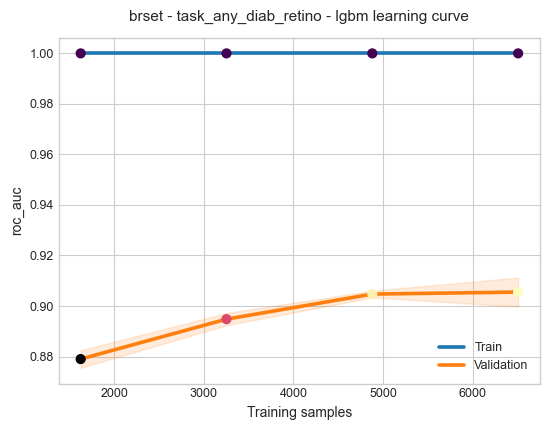

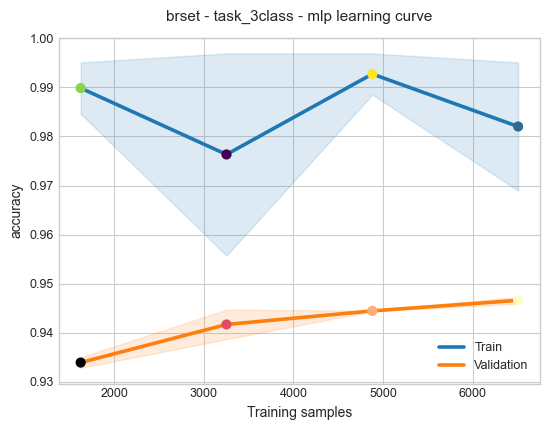

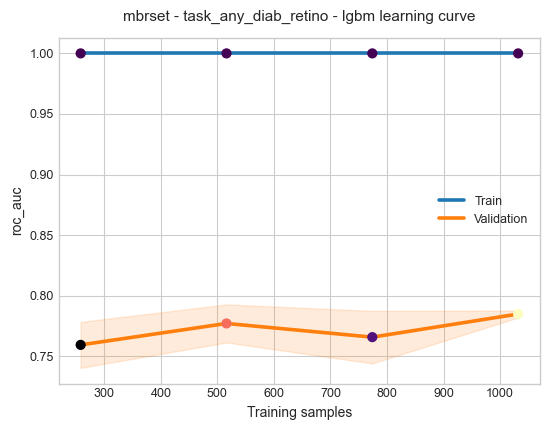

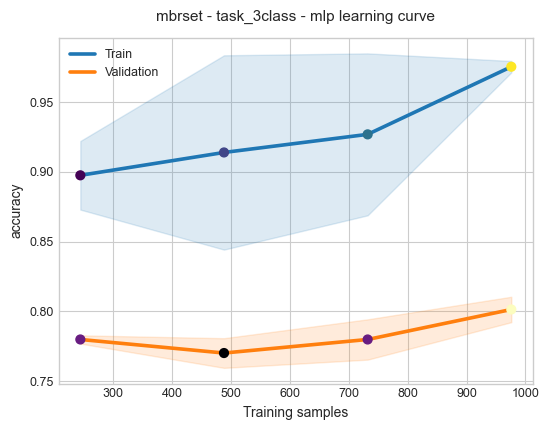

In [20]:
# Overfitting check: pick dataset/task/model to visualize
# BRSET examples
plot_overfitting_checks(dataset_name="brset", view="all", task="task_any_dr", model_name="lgbm")
plot_overfitting_checks(dataset_name="brset", view="all", task="task_3class", model_name="mlp")

# MBRSET examples
plot_overfitting_checks(dataset_name="mbrset", view="macula", task="task_any_dr", model_name="lgbm")
plot_overfitting_checks(dataset_name="mbrset", view="macula", task="task_3class", model_name="mlp")


[brset] Detailed evaluation on: (0) Embeddings_brset_convnextv2_base_.csv

[brset] task_any_diab_retino | lgbm
              precision    recall  f1-score   support

           0      0.960     0.996     0.977      3051
           1      0.849     0.365     0.510       200

    accuracy                          0.957      3251
   macro avg      0.904     0.680     0.744      3251
weighted avg      0.953     0.957     0.949      3251



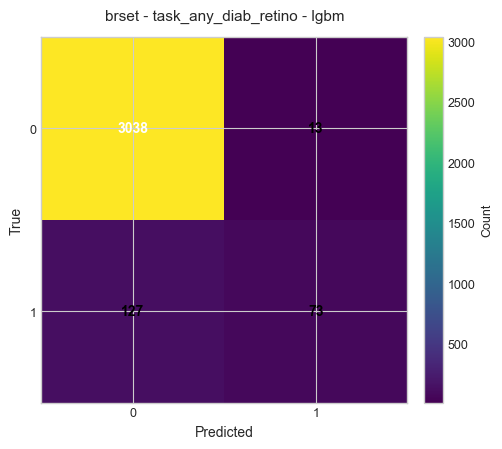

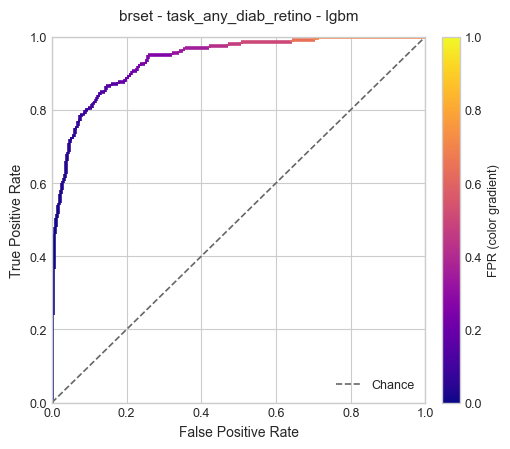


[brset] task_any_diab_retino | mlp
              precision    recall  f1-score   support

           0      0.969     0.987     0.978      3051
           1      0.719     0.525     0.607       200

    accuracy                          0.958      3251
   macro avg      0.844     0.756     0.792      3251
weighted avg      0.954     0.958     0.955      3251



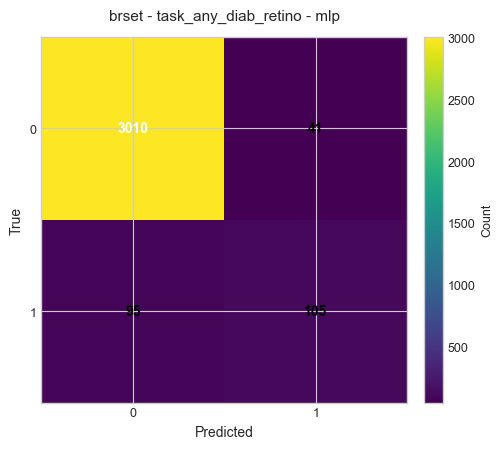

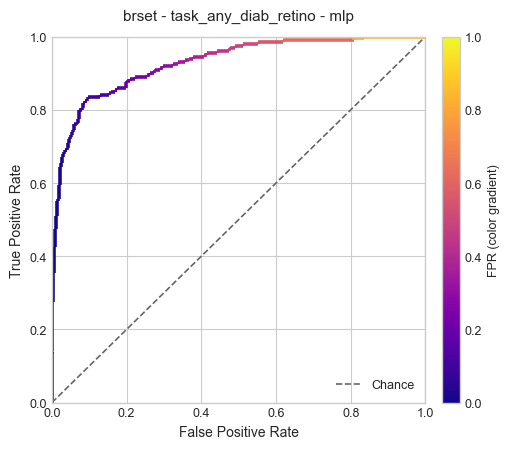


[brset] task_ref_macular | lgbm
              precision    recall  f1-score   support

           0      0.966     0.996     0.981      3075
           1      0.841     0.392     0.535       176

    accuracy                          0.963      3251
   macro avg      0.904     0.694     0.758      3251
weighted avg      0.959     0.963     0.957      3251



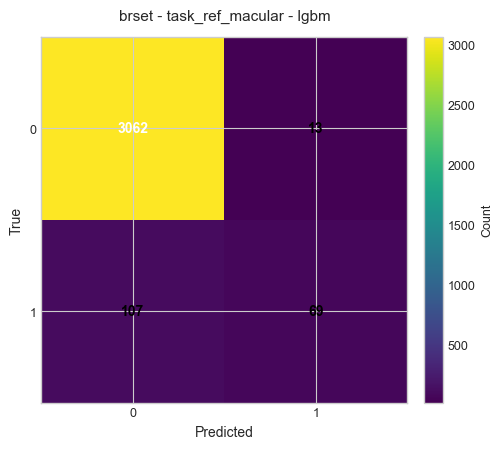

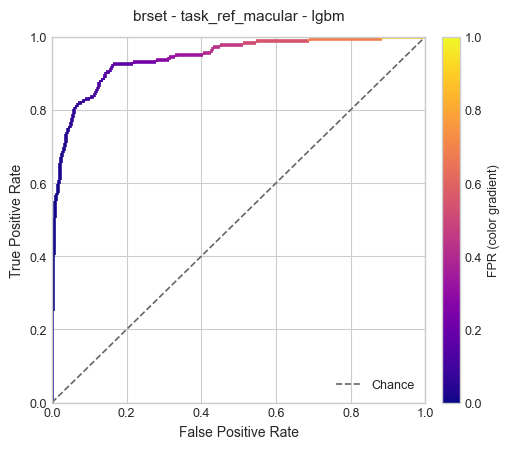


[brset] task_ref_macular | mlp
              precision    recall  f1-score   support

           0      0.976     0.991     0.983      3075
           1      0.777     0.574     0.660       176

    accuracy                          0.968      3251
   macro avg      0.876     0.782     0.822      3251
weighted avg      0.965     0.968     0.966      3251



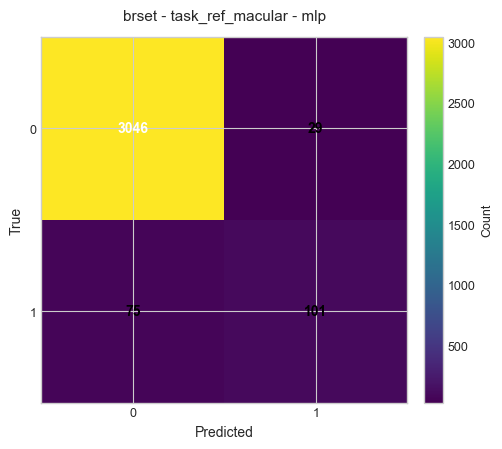

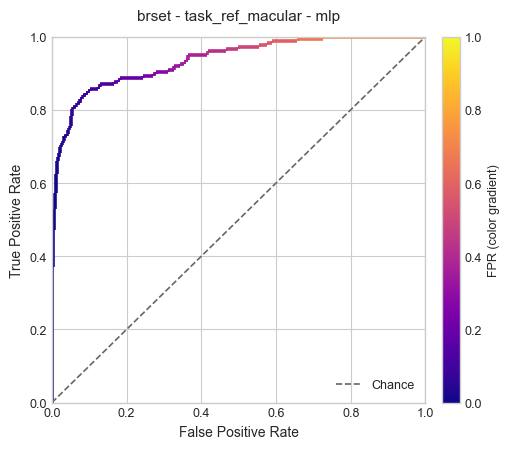


[brset] task_3class | lgbm
              precision    recall  f1-score   support

           0      0.958     0.997     0.977      3051
           1      0.708     0.145     0.241       117
           2      0.780     0.470     0.586        83

    accuracy                          0.953      3251
   macro avg      0.815     0.537     0.601      3251
weighted avg      0.944     0.953     0.940      3251



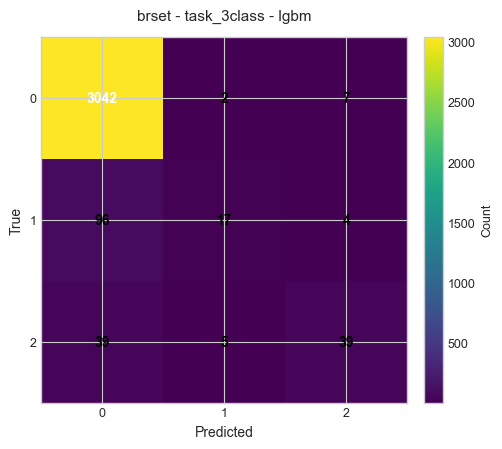


[brset] task_3class | mlp
              precision    recall  f1-score   support

           0      0.969     0.983     0.976      3051
           1      0.425     0.265     0.326       117
           2      0.659     0.675     0.667        83

    accuracy                          0.949      3251
   macro avg      0.684     0.641     0.656      3251
weighted avg      0.942     0.949     0.945      3251



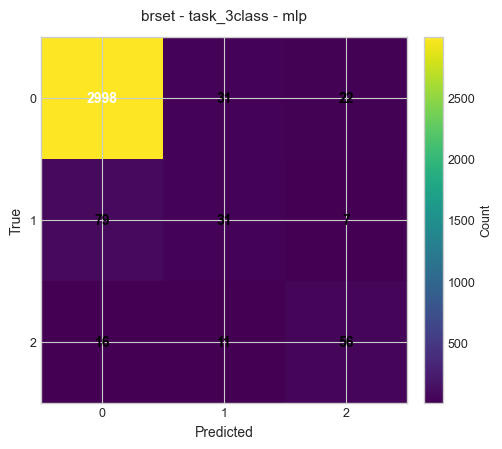


[mbrset] Detailed evaluation on: (0) Embeddings_convnextv2_base_mbrset.csv

[mbrset] task_any_diab_retino | lgbm
              precision    recall  f1-score   support

           0      0.834     0.960     0.893       399
           1      0.729     0.361     0.483       119

    accuracy                          0.822       518
   macro avg      0.782     0.661     0.688       518
weighted avg      0.810     0.822     0.799       518



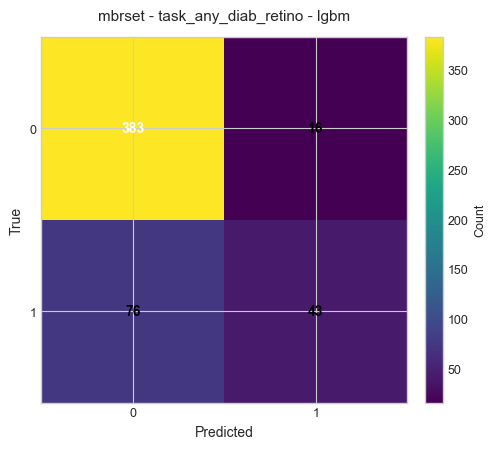

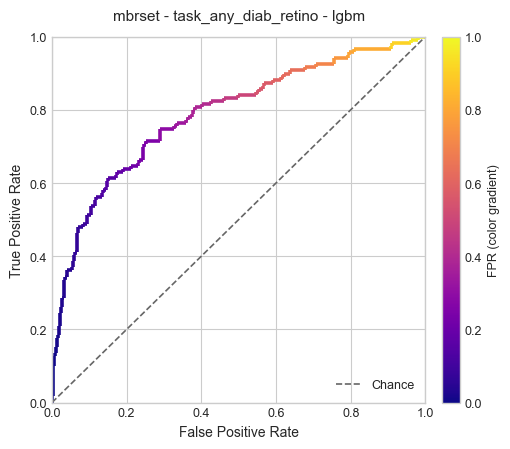


[mbrset] task_any_diab_retino | mlp
              precision    recall  f1-score   support

           0      0.852     0.940     0.894       399
           1      0.692     0.454     0.548       119

    accuracy                          0.828       518
   macro avg      0.772     0.697     0.721       518
weighted avg      0.816     0.828     0.815       518



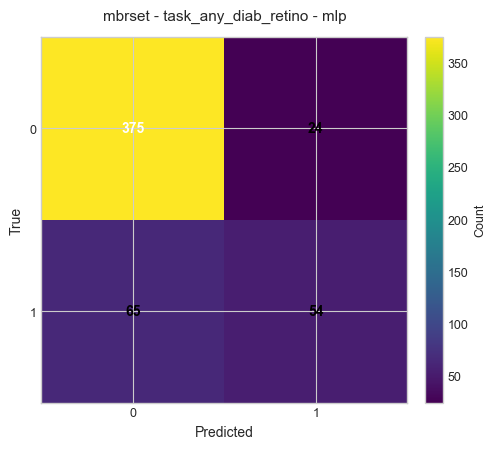

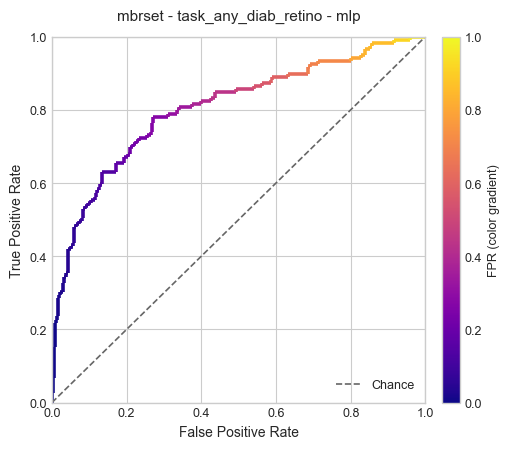


[mbrset] task_ref_macular | lgbm
              precision    recall  f1-score   support

           0      0.887     0.962     0.923       426
           1      0.714     0.435     0.541        92

    accuracy                          0.869       518
   macro avg      0.801     0.699     0.732       518
weighted avg      0.857     0.869     0.855       518



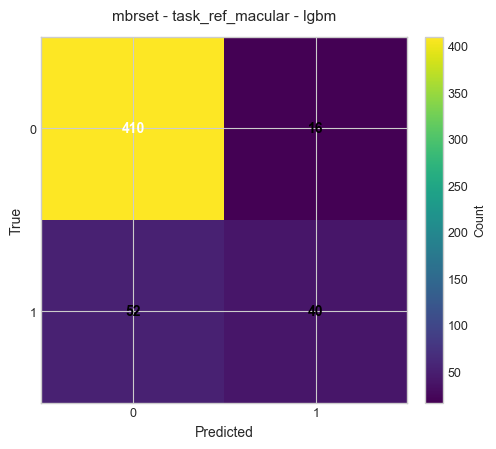

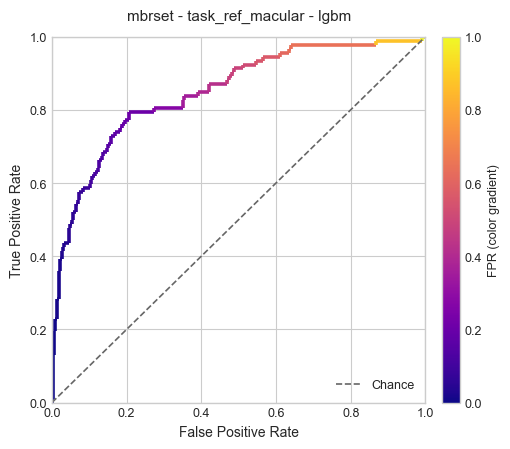


[mbrset] task_ref_macular | mlp
              precision    recall  f1-score   support

           0      0.893     0.960     0.925       426
           1      0.717     0.467     0.566        92

    accuracy                          0.873       518
   macro avg      0.805     0.714     0.746       518
weighted avg      0.862     0.873     0.861       518



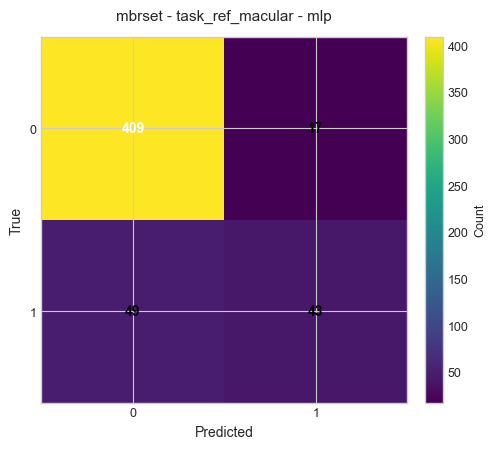

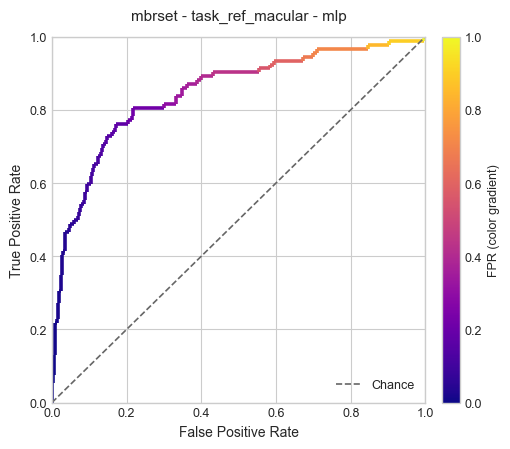


[mbrset] task_3class | lgbm
              precision    recall  f1-score   support

           0      0.818     0.959     0.883       365
           1      0.646     0.301     0.411       103
           2      0.500     0.250     0.333        16

    accuracy                          0.795       484
   macro avg      0.655     0.503     0.542       484
weighted avg      0.771     0.795     0.764       484



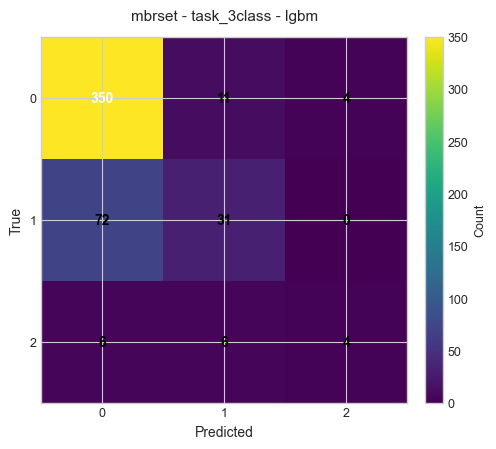


[mbrset] task_3class | mlp
              precision    recall  f1-score   support

           0      0.851     0.921     0.884       365
           1      0.547     0.398     0.461       103
           2      0.357     0.312     0.333        16

    accuracy                          0.789       484
   macro avg      0.585     0.544     0.559       484
weighted avg      0.770     0.789     0.776       484



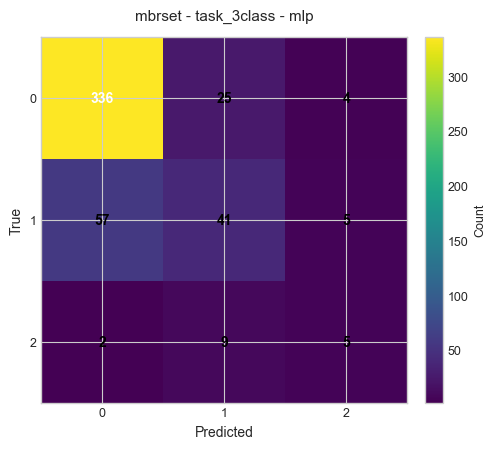

In [ ]:
# Detailed evaluation plots (holdout/"test" set): classification report, confusion matrix, ROC

# Pick which embeddings file to inspect per dataset:
# - Use EMBEDDING_INDEX (0-based), OR
# - Set EMBEDDING_MATCH to a substring (e.g. "dinov3"), which will select the first matching file.
EMBEDDING_INDEX = 0
EMBEDDING_MATCH = None  # e.g. "RETFound" or "dinov3"
SHOW_AVAILABLE_EMBEDDINGS = False

from typing import Optional, Tuple

def _select_embedding_file(embedding_files, index: int = 0, match: Optional[str] = None) -> Tuple[int, Path]:
    if not embedding_files:
        raise FileNotFoundError("No embeddings CSV files found.")

    if match:
        m = match.lower()
        for i, p in enumerate(embedding_files):
            if m in p.name.lower() or m in p.stem.lower():
                return i, p
        raise ValueError(
            f"No embedding file matched '{match}'. Available: {[p.name for p in embedding_files]}"
        )

    if index is None:
        index = 0
    if index < 0 or index >= len(embedding_files):
        raise IndexError(f"EMBEDDING_INDEX={index} out of range (0..{len(embedding_files)-1}).")
    return index, embedding_files[index]


for cfg in DATASETS:
    dataset_name = cfg["name"]
    view = cfg["view"]
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)

    if SHOW_AVAILABLE_EMBEDDINGS:
        print(f"\n[{dataset_name}] Available embeddings:")
        for i, p in enumerate(embedding_files):
            print(f"  {i:02d}: {p.name}")

    chosen_idx, emb_path = _select_embedding_file(
        embedding_files,
        index=EMBEDDING_INDEX,
        match=EMBEDDING_MATCH,
    )
    print(f"\n[{dataset_name}] Detailed evaluation on: ({chosen_idx}) {emb_path.name}")

    ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=emb_path,
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )
    train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

    tasks = list(BINARY_TASKS)
    if "task_3class" in ds.df.columns:
        tasks.append("task_3class")

    for task in tasks:
        task_type = "binary" if task in BINARY_TASKS else "multiclass"
        display_name = BINARY_TASK_MAP.get(task, task)
        for model_name in MODEL_NAMES:
            model = reval.train_holdout_model(
                train_df=train_df,
                feature_cols=ds.feature_cols,
                label_col=task,
                model_name=model_name,
                seed=RANDOM_SEED,
            )
            report = reval.evaluate_holdout_classification(
                model=model,
                val_df=val_df,
                feature_cols=ds.feature_cols,
                label_col=task,
                task_type=task_type,
            )
            print(f"\n[{dataset_name}] {display_name} | {model_name}")
            print(report.classification_report)
            _plot_confusion_matrix(report.confusion_matrix, title=f"{dataset_name} - {display_name} - {model_name}")
            if task_type == "binary":
                _plot_roc_curve(report.roc_curve, title=f"{dataset_name} - {display_name} - {model_name}")

In [26]:
# Detailed evaluation (RETFound dinov2 shanghai) + save outputs to disk

# This cell runs the same detailed holdout evaluation, but forces the embedding selection to
# RETFound DINOv2 Shanghai, and saves reports + plots for later inspection.

from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

EMBEDDING_MATCH = "RETFound_dinov2_shanghai"  # substring match in filename/stem
OUT_DIR = PROJECT_ROOT / "results" / "detailed_eval" / EMBEDDING_MATCH
OUT_DIR.mkdir(parents=True, exist_ok=True)

def _safe_name(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9._-]+", "_", s)
    return s[:180]

def _save_text(path: Path, text: str):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(text, encoding="utf-8")

def _plot_confusion_matrix_save(cm, title: str, out_path: Path):
    cm = np.asarray(cm)
    fig, ax = plt.subplots(figsize=(5.2, 4.6))
    im = ax.imshow(cm, cmap="viridis", interpolation="nearest")
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("True", fontsize=10)
    ax.set_xticks(range(cm.shape[1]))
    ax.set_yticks(range(cm.shape[0]))
    ax.tick_params(axis="both", labelsize=9)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    cbar.set_label("Count", fontsize=9)

    thresh = cm.max() / 2.0 if cm.size else 0
    for (i, j), val in np.ndenumerate(cm):
        ax.text(
            j,
            i,
            f"{val}",
            ha="center",
            va="center",
            color="white" if val > thresh else "black",
            fontsize=10,
            fontweight="bold",
        )
    fig.tight_layout()
    fig.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close(fig)

def _plot_roc_curve_save(roc_data, title: str, out_path: Path):
    if roc_data is None:
        return False
    fpr, tpr, _ = roc_data
    fig, ax = plt.subplots(figsize=(5.2, 4.6))

    points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = Normalize(vmin=0.0, vmax=1.0)
    lc = LineCollection(segments, cmap="plasma", norm=norm)
    lc.set_array(fpr)
    lc.set_linewidth(2.6)
    ax.add_collection(lc)

    ax.plot([0, 1], [0, 1], linestyle="--", color="#666", linewidth=1.2, label="Chance")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=11, pad=12)
    ax.set_xlabel("False Positive Rate", fontsize=10)
    ax.set_ylabel("True Positive Rate", fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.legend(loc="lower right", fontsize=9)
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("FPR (color gradient)", fontsize=9)
    cbar.ax.tick_params(labelsize=9)
    fig.tight_layout()
    fig.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close(fig)
    return True

saved_reports = {}  # (dataset, embeddings, task, model) -> HoldoutReport

for cfg in DATASETS:
    dataset_name = cfg["name"]
    view = cfg["view"]
    embed_dir, labels_path = _paths_for_dataset(dataset_name)
    embedding_files = list_embeddings_csvs(embed_dir)
    chosen_idx, emb_path = _select_embedding_file(embedding_files, index=0, match=EMBEDDING_MATCH)

    ds = load_retina_embeddings_dataset(
        dataset=dataset_name,
        embeddings_csv_path=emb_path,
        labels_csv_path=labels_path,
        view=view,
    )
    split = reval.make_patient_split(
        df=ds.df,
        group_col="patient_id",
        label_col="task_any_dr",
        val_frac=VAL_FRAC,
        seed=RANDOM_SEED,
    )
    train_df, val_df = reval.apply_patient_split(ds.df, split, group_col="patient_id")

    tasks = list(BINARY_TASKS)
    if "task_3class" in ds.df.columns:
        tasks.append("task_3class")

    for task in tasks:
        task_type = "binary" if task in BINARY_TASKS else "multiclass"
        display_name = BINARY_TASK_MAP.get(task, task)
        for model_name in MODEL_NAMES:
            model = reval.train_holdout_model(
                train_df=train_df,
                feature_cols=ds.feature_cols,
                label_col=task,
                model_name=model_name,
                seed=RANDOM_SEED,
            )
            report = reval.evaluate_holdout_classification(
                model=model,
                val_df=val_df,
                feature_cols=ds.feature_cols,
                label_col=task,
                task_type=task_type,
            )

            key = (dataset_name, emb_path.stem, display_name, model_name)
            saved_reports[key] = report

            base = _safe_name(f"{dataset_name}__{emb_path.stem}__{display_name}__{model_name}")
            out_prefix = OUT_DIR / dataset_name / base

            # Save classification report
            _save_text(Path(str(out_prefix) + ".txt"), report.classification_report)

            # Save confusion matrix + numeric CSV
            pd.DataFrame(report.confusion_matrix).to_csv(Path(str(out_prefix) + "_cm.csv"), index=False)
            _plot_confusion_matrix_save(
                report.confusion_matrix,
                title=f"{dataset_name} - {display_name} - {model_name}",
                out_path=Path(str(out_prefix) + "_cm.png"),
            )

            # Save ROC curve (binary tasks only)
            if task_type == "binary":
                roc_png = Path(str(out_prefix) + "_roc.png")
                ok = _plot_roc_curve_save(
                    report.roc_curve,
                    title=f"{dataset_name} - {display_name} - {model_name}",
                    out_path=roc_png,
                )
                if ok and report.roc_curve is not None:
                    fpr, tpr, thr = report.roc_curve
                    pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thr}).to_csv(
                        Path(str(out_prefix) + "_roc.csv"), index=False
                    )

print(f"Saved detailed evaluation outputs under: {OUT_DIR}")
print(f"Saved reports in-memory: {len(saved_reports)} combinations")

Saved detailed evaluation outputs under: c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\detailed_eval\RETFound_dinov2_shanghai
Saved reports in-memory: 12 combinations
